In [15]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score , accuracy_score
from tqdm import tqdm

In [19]:
from sklearn.model_selection import train_test_split
dataset_root = "D:/DEEP Leaning dataset/shop videos/Shop DataSet"
categories = ["shop lifters", "non shop lifters"]
video_files = []
labels = []
for category in categories:
    category_path = os.path.join(dataset_root, category)
    for video in os.listdir(category_path):
        video_files.append(os.path.join(category_path, video))
        labels.append(1 if category == "shop lifters" else 0)
train_videos, temp_videos, train_labels, temp_labels = train_test_split(
    video_files, labels, test_size=0.3, stratify=labels, random_state=42)
val_videos, test_videos, val_labels, test_labels = train_test_split(
    temp_videos, temp_labels, test_size=1/3, stratify=temp_labels, random_state=42)
print(f"Train: {len(train_videos)}, Validation: {len(val_videos)}, Test: {len(test_videos)}")



Train: 445, Validation: 127, Test: 64


In [20]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_frames=70):
        self.root_dir = root_dir
        self.transform = transform
        self.max_frames = max_frames
        self.video_list = []
        self.labels = []
        self.class_to_idx = {"shop lifters": 0, "non shop lifters": 1}
        for class_name in ["shop lifters", "non shop lifters"]:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(".mp4"):
                    video_path = os.path.join(class_dir, filename)
                    self.video_list.append(video_path)
                    self.labels.append(self.class_to_idx[class_name])
    def __len__(self):
        return len(self.video_list)
    def __getitem__(self, idx):
        video_path = self.video_list[idx]
        label = self.labels[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (224, 224))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        if len(frames) < self.max_frames:
            pad = [np.zeros((224, 224, 3), dtype=np.uint8)] * (self.max_frames - len(frames))
            frames.extend(pad)
        else:
            frames = frames[:self.max_frames]
        frames = torch.tensor(np.array(frames), dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (T, C, H, W)
        label = torch.tensor(label, dtype=torch.long)
        return frames, label
#--------------------------------------------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = VideoDataset(root_dir="D:/DEEP Leaning dataset/shop videos/Shop DataSet", transform=transform)
val_dataset = VideoDataset(root_dir="D:/DEEP Leaning dataset/shop videos/Shop DataSet", transform=transform)
test_dataset = VideoDataset(root_dir="D:/DEEP Leaning dataset/shop videos/Shop DataSet", transform=transform)
#--------------------------------------------------------------------------------------------------------------
num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)
num_test_samples = len(test_dataset)
train_batch_size = max(1, num_train_samples // 155)  
val_batch_size = max(1, num_val_samples // 155)
test_batch_size = max(1, num_test_samples // 155)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size , shuffle=False, num_workers=0)
print(f"Train: {len(train_loader)}, Validation: {len(val_loader)}, Test: {len(test_loader)}")

Train: 159, Validation: 159, Test: 159


In [21]:
class ResNet34FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet34FeatureExtractor, self).__init__()
        resnet = models.resnet34(weights=None)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape
        x = x.view(batch_size * seq_len, C, H, W)
        features = self.feature_extractor(x)
        features = features.view(batch_size, seq_len, -1)
        return features
#-------------------------------------------------------------------------------------------------------------
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2, num_classes=2):
        super(CNN_LSTM, self).__init__()
        self.cnn = ResNet34FeatureExtractor()
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        features = self.cnn(x)
        lstm_out, _ = self.lstm(features)
        last_frame_features = lstm_out[:, -1, :]
        out = self.fc(last_frame_features)
        return out

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [13]:
def train(model, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
        for videos, labels in train_loop:
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            train_loop.set_postfix(loss=total_loss / (total + 1e-6), acc=100 * correct / total)
        train_acc = 100 * correct / total
        train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        print(f"\nEpoch {epoch+1}/{num_epochs} -> Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%, Train Precision: {train_precision:.2f}, Train F1: {train_f1:.2f}")
        evaluate(model, val_loader)
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Validation -> Loss: {total_loss / len(val_loader):.4f}, Acc: {val_acc:.2f}%, Precision: {val_precision:.2f}, F1: {val_f1:.2f}\n")


In [14]:
num_epochs = 7
train(model, train_loader, val_loader, num_epochs)

Epoch 1/7: 100%|██████████| 159/159 [1:57:37<00:00, 44.38s/it, acc=50.2, loss=0.179]



Epoch 1/7 -> Train Loss: 113.8028, Train Acc: 50.16%, Train Precision: 0.50, Train F1: 0.50
Validation -> Loss: 0.6941, Acc: 51.10%, Precision: 0.26, F1: 0.35



Epoch 2/7: 100%|██████████| 159/159 [1:55:09<00:00, 43.45s/it, acc=49.8, loss=0.174]



Epoch 2/7 -> Train Loss: 110.5983, Train Acc: 49.84%, Train Precision: 0.45, Train F1: 0.37
Validation -> Loss: 0.6933, Acc: 51.10%, Precision: 0.26, F1: 0.35



Epoch 3/7: 100%|██████████| 159/159 [1:53:44<00:00, 42.92s/it, acc=50.2, loss=0.173]



Epoch 3/7 -> Train Loss: 110.3453, Train Acc: 50.16%, Train Precision: 0.49, Train F1: 0.46
Validation -> Loss: 0.6933, Acc: 48.90%, Precision: 0.24, F1: 0.32



Epoch 4/7: 100%|██████████| 159/159 [1:55:32<00:00, 43.60s/it, acc=48.3, loss=0.174]



Epoch 4/7 -> Train Loss: 110.4399, Train Acc: 48.27%, Train Precision: 0.48, Train F1: 0.47
Validation -> Loss: 0.6929, Acc: 51.10%, Precision: 0.26, F1: 0.35



Epoch 5/7: 100%|██████████| 159/159 [1:58:16<00:00, 44.63s/it, acc=49.5, loss=0.173]



Epoch 5/7 -> Train Loss: 110.3162, Train Acc: 49.53%, Train Precision: 0.49, Train F1: 0.49
Validation -> Loss: 0.6933, Acc: 51.10%, Precision: 0.26, F1: 0.35



Epoch 6/7: 100%|██████████| 159/159 [2:17:14<00:00, 51.79s/it, acc=51.1, loss=0.174]



Epoch 6/7 -> Train Loss: 110.3540, Train Acc: 51.10%, Train Precision: 0.26, Train F1: 0.35
Validation -> Loss: 0.6930, Acc: 51.10%, Precision: 0.26, F1: 0.35



Epoch 7/7: 100%|██████████| 159/159 [1:54:28<00:00, 43.20s/it, acc=50.8, loss=0.173]



Epoch 7/7 -> Train Loss: 110.3300, Train Acc: 50.79%, Train Precision: 0.51, Train F1: 0.51
Validation -> Loss: 0.6930, Acc: 51.10%, Precision: 0.26, F1: 0.35



In [16]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        test_loop = tqdm(test_loader, desc="Testing", leave=True)
        for videos, labels in test_loop:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")

    return accuracy, precision, recall, f1
test_model(model, test_loader)

Testing: 100%|██████████| 159/159 [43:07<00:00, 16.27s/it]

Accuracy  : 0.5110
Precision : 0.7501
Recall    : 0.5110
F1 Score  : 0.3456


(0.5110062893081762,
 np.float64(0.7501211384043353),
 np.float64(0.5110062893081762),
 np.float64(0.3456338065039693))

Testing: 100%|██████████| 159/159 [37:09<00:00, 14.03s/it]


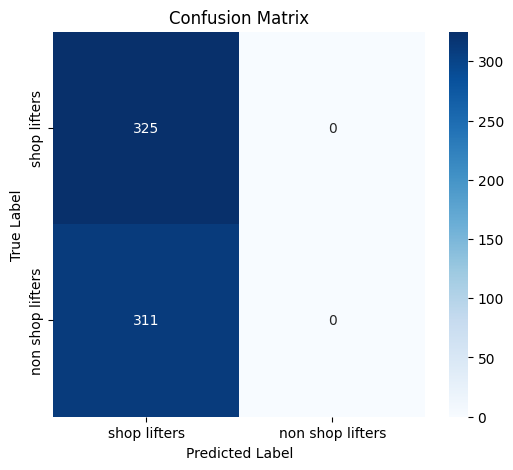

array([[325,   0],
       [311,   0]])

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def test_model_with_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        test_loop = tqdm(test_loader, desc="Testing", leave=True)
        for videos, labels in test_loop:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1) 
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    return cm
class_names =["shop lifters", "non shop lifters"]
test_model_with_confusion_matrix(model, test_loader, class_names)
